In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd
import warnings
warnings.filterwarnings('ignore')

# 整理充电和等待订单

In [2]:
station_info = pd.read_csv('output/station_infos.csv')
# 仿真步长
step_length = 60

import ast
station_info_table = station_info[['station_id','lon','lat','max_capacity','charge_speed_station']].drop_duplicates().copy()
station_info = station_info[['station_id','time','current_car','waiting_car']]

station_info['time'] = pd.to_datetime(station_info['time'])
station_info['current_car'] = station_info['current_car'].apply(lambda a:ast.literal_eval(a))
station_info['waiting_car'] = station_info['waiting_car'].apply(lambda a:ast.literal_eval(a))
# 将current_car和waiting_car列转换为车辆记录的列表
current_car_infos = station_info[['station_id','time','current_car']].explode('current_car')
current_car_infos = current_car_infos[~current_car_infos['current_car'].isnull()]
current_car_infos = current_car_infos.sort_values(by=['current_car','time'])[['current_car','time','station_id']]
waiting_car_infos = station_info[['station_id','time','waiting_car']].explode('waiting_car')
waiting_car_infos = waiting_car_infos[~waiting_car_infos['waiting_car'].isnull()]
waiting_car_infos = waiting_car_infos.sort_values(by=['waiting_car','time'])[['waiting_car','time','station_id']]

def get_charging_order(current_car_infos):
    current_car_infos['timegap'] = current_car_infos['time'].diff().dt.total_seconds().fillna(1000000).astype(int)
    current_car_infos['order_id'] = (current_car_infos['timegap']>step_length).cumsum()
    charge_info_s = current_car_infos.groupby(['current_car','order_id']).first().reset_index()
    charge_info_e = current_car_infos.groupby(['current_car','order_id']).last().reset_index()
    charging_order = pd.merge(charge_info_s,charge_info_e,on=['current_car','order_id','station_id'])
    charging_order
    charging_order = charging_order[['current_car','order_id','time_x','time_y','station_id']]
    charging_order.columns = ['carid','order_id','stime','etime','station_id']
    charging_order['duration'] = (charging_order['etime']-charging_order['stime']).dt.total_seconds()
    charging_order = charging_order[charging_order['duration']>0]
    return charging_order
# 计算充电信息
charging_orders = get_charging_order(current_car_infos)
# 计算等待信息
waiting_orders =  get_charging_order(waiting_car_infos.rename(columns={'waiting_car':'current_car'}))
# 保存充电信息和等待信息
charging_orders = pd.merge(charging_orders,station_info_table)
waiting_orders = pd.merge(waiting_orders,station_info_table)
# 计算充电时长
charging_orders['duration'] = (charging_orders['etime']-charging_orders['stime']).dt.total_seconds()
waiting_orders['duration'] = (waiting_orders['etime']-waiting_orders['stime']).dt.total_seconds()


charging_orders.to_csv('output/charging_orders_from_station.csv',index=False)
waiting_orders.to_csv('output/waiting_orders_from_station.csv',index=False)

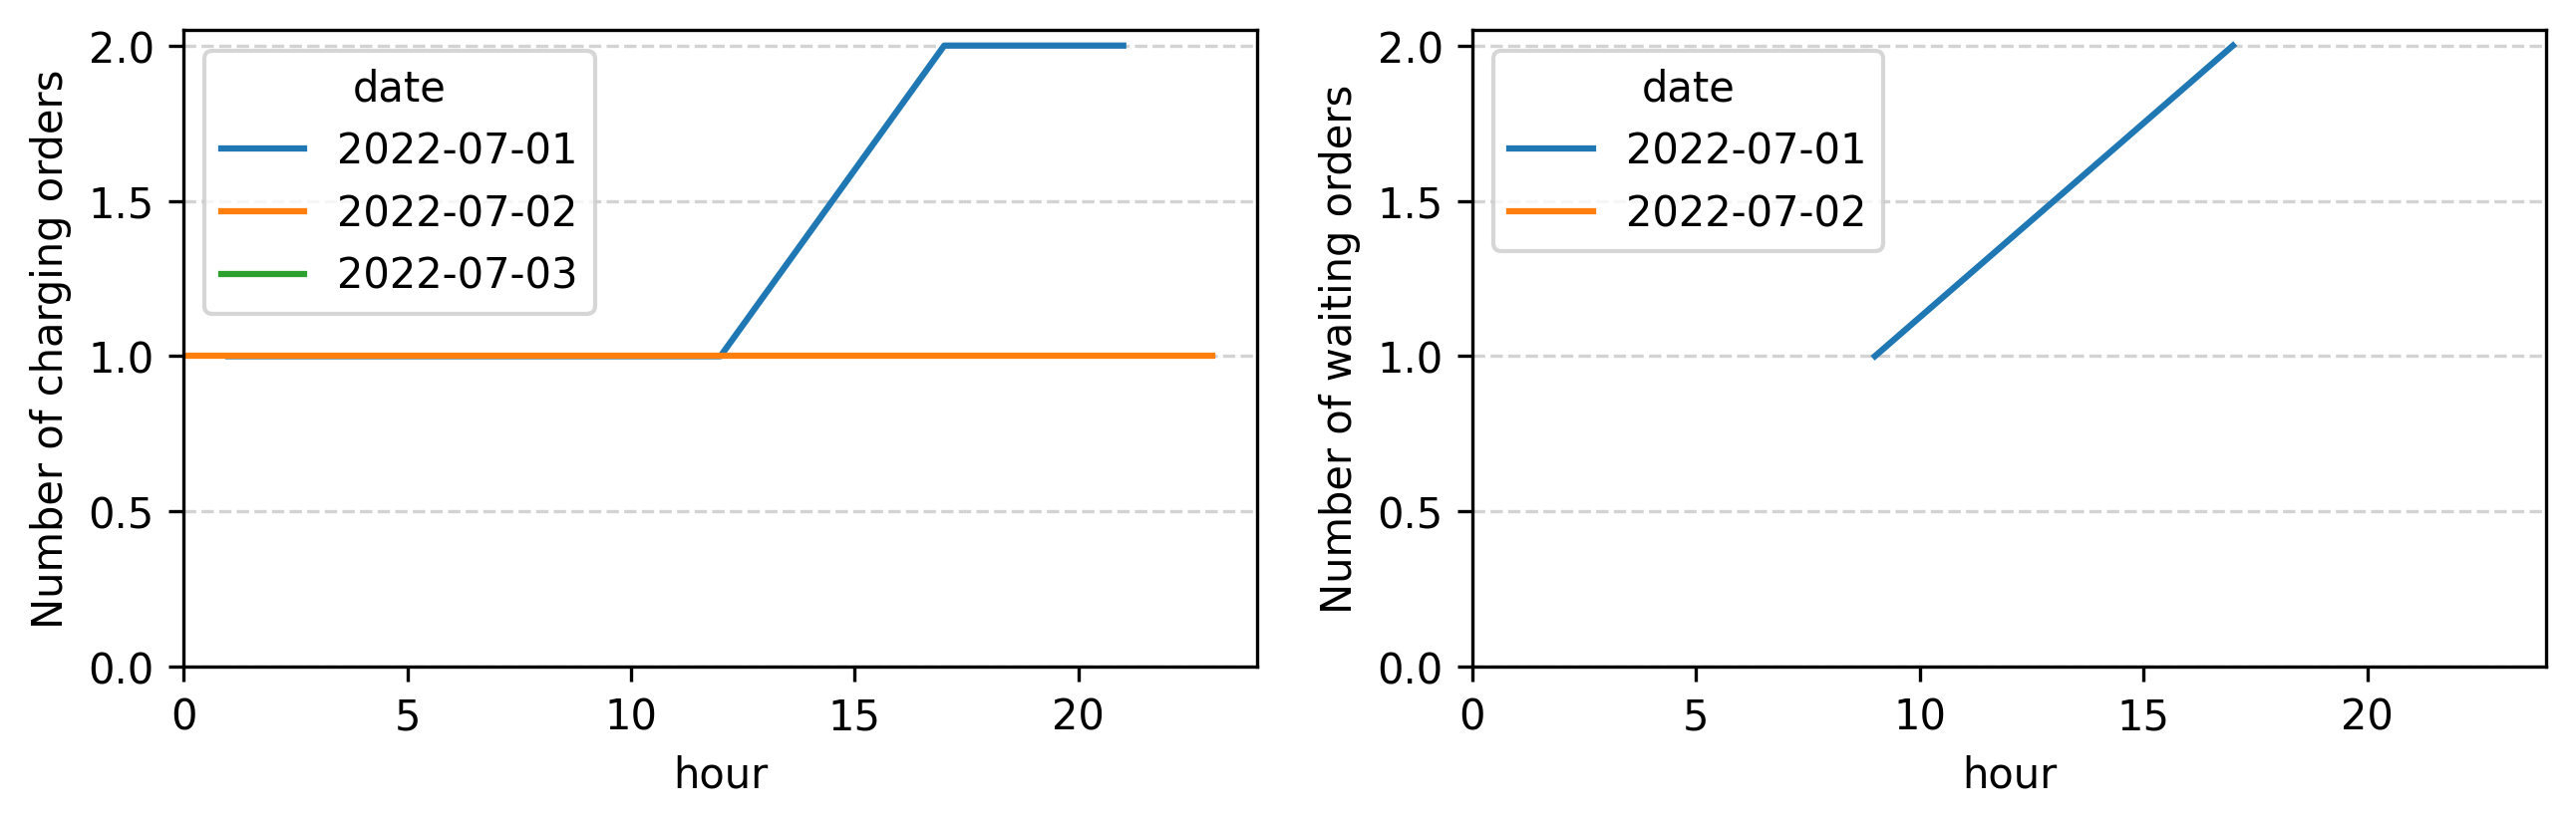

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

charging_orders['date'] = charging_orders['stime'].dt.date
charging_orders['hour'] = charging_orders['stime'].dt.hour
waiting_orders['date'] = waiting_orders['stime'].dt.date
waiting_orders['hour'] = waiting_orders['stime'].dt.hour
charging_orders_agg = charging_orders.groupby(['date','hour'])['carid'].count().reset_index()
waiting_orders_agg = waiting_orders.groupby(['date','hour'])['carid'].count().reset_index()

fig = plt.figure(1, (10, 3), dpi=300)
ax = plt.subplot(121)
plt.subplots_adjust(left=0.19,right=0.98,top=0.9,bottom=0.19)
sns.lineplot(data=charging_orders_agg,x='hour',y='carid',hue = 'date',ax=ax)
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', color='lightgray', zorder=0)
plt.ylabel('Number of charging orders')
plt.ylim(0)
plt.xlim(0,24)
ax = plt.subplot(122)
sns.lineplot(data=waiting_orders_agg,x='hour',y='carid',hue = 'date',ax=ax)
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', color='lightgray', zorder=0)
plt.ylabel('Number of waiting orders')
plt.ylim(0)
plt.xlim(0,24)
plt.show()

# 整理车辆充电信息

In [28]:

car_infos = pd.read_csv('output/car_infos1.csv')
step_length = 300

# 充电订单识别
car_infos['time'] = pd.to_datetime(car_infos['time'])
charge_infos = car_infos[car_infos['status'] == 2]
charge_infos = charge_infos.sort_values(by=['carid','time'])
charge_infos['timegap'] = charge_infos['time'].diff().dt.total_seconds().fillna(1000000).astype(int)
charge_infos['order_id'] = (charge_infos['timegap']>step_length).cumsum()
charge_info_s = charge_infos.groupby(['carid','order_id']).first().reset_index()
charge_info_e = charge_infos.groupby(['carid','order_id']).last().reset_index()
charging_order = pd.merge(charge_info_s,charge_info_e,on=['carid','order_id'])
charging_order = charging_order[['carid','order_id','time_x','time_y','soc_x','soc_y','lon_x','lat_x']]
charging_order.columns = ['carid','order_id','stime','etime','soc_start','soc_end','lon','lat']
charging_order['duration'] = (charging_order['etime']-charging_order['stime']).dt.total_seconds()
charging_order = charging_order[charging_order['duration']>0]
charging_order.to_csv('output/charging_orders_from_car.csv',index=False)

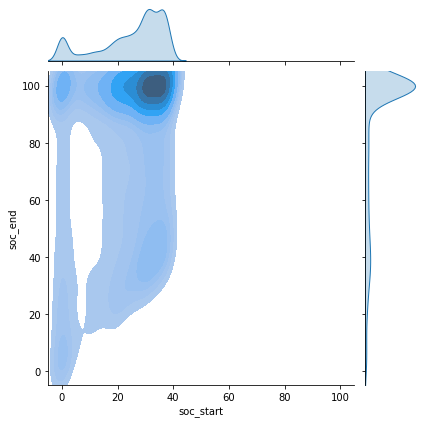

In [39]:
#充电开始与结束的电量统计
sns.jointplot(x='soc_start',
              y='soc_end', 
              data = charging_order.sample(10000),
              kind='kde',
              xlim=(-5,105),
              ylim=(-5,105),
               fill=True  # 填充颜色
              )